# Test Posos - B

# 1- Chargement des données¶

In [2]:
import numpy as np
from numpy import array
from numpy import argmax
import pandas as pd
import seaborn as sns
%matplotlib inline
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import SnowballStemmer
import nltk
import re
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional, Embedding, Dropout
from keras.callbacks import ModelCheckpoint
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb


Using TensorFlow backend.
/Users/vsaliba-/goinfre/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/vsaliba-/goinfre/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/vsaliba-/goinfre/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/vsaliba-/goin

In [3]:
df_input = pd.read_csv("input_train.csv", encoding = "utf8")
df_input

,ID,question
0,0,"bonjour, je m suis trompé de forum pour ma qu..."
1,1,est ce que le motilium me soulagera contre les...
2,2,mon médecin m'a prescrit adenyl. au 2ème cache...
3,3,Est-ce qu'il existe une forme adaptée aux enfa...
4,4,mon medecin me soigne pour une rhino pha...
...,...,...
8023,8023,en combien de temps un antibio n'est plus prés...
8024,8024,j'ai fait vacciner de revaxis mon fils 'année ...
8025,8025,Un patient m’a ramené une ordonnance de 3x1g d...
8026,8026,"prise pillule du lendemain, faire une pause en..."


In [4]:
df_input.columns

Index(['ID', 'question'], dtype='object')

In [5]:
df_output = pd.read_csv("output_train.csv", encoding = "utf8")
df_output

,ID,intention
0,0,28
1,1,31
2,2,28
3,3,44
4,4,31
...,...,...
8023,8023,41
8024,8024,48
8025,8025,42
8026,8026,14


In [6]:
df = pd.merge(df_input,df_output,on='ID') 
df

,ID,question,intention
0,0,"bonjour, je m suis trompé de forum pour ma qu...",28
1,1,est ce que le motilium me soulagera contre les...,31
2,2,mon médecin m'a prescrit adenyl. au 2ème cache...,28
3,3,Est-ce qu'il existe une forme adaptée aux enfa...,44
4,4,mon medecin me soigne pour une rhino pha...,31
...,...,...,...
8023,8023,en combien de temps un antibio n'est plus prés...,41
8024,8024,j'ai fait vacciner de revaxis mon fils 'année ...,48
8025,8025,Un patient m’a ramené une ordonnance de 3x1g d...,42
8026,8026,"prise pillule du lendemain, faire une pause en...",14


# 2- Data cleaning


In [7]:
df['len_question'] = df['question'].apply(len)
df['len_question'] 

0       410
1        55
2       321
3        73
4       150
       ... 
8023     65
8024    119
8025    153
8026     52
8027     17
Name: len_question, Length: 8028, dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8028 entries, 0 to 8027
Data columns (total 4 columns):
ID              8028 non-null int64
question        8028 non-null object
intention       8028 non-null int64
len_question    8028 non-null int64
dtypes: int64(3), object(1)
memory usage: 313.6+ KB


In [9]:
#on voit que peu de questions sont hyper longues
df.sort_values(by = 'len_question')


,ID,question,intention,len_question
3310,3310,xanax,22,5
6266,6266,Hello,1,5
342,342,REJET,14,5
3970,3970,ixel ?,22,6
556,556,norset,22,6
...,...,...,...,...
503,503,"bonjour, je souhaiterais savoir auprès de ceux...",26,1866
7956,7956,bonjour je suis perdue.. apres presque 6 mois ...,11,1907
961,961,je ne pensais pas avoir ce problème quand j'ai...,28,2008
1363,1363,"je prends effexor lp depuis des années, de 1 à...",0,2318


In [10]:
#j'ai supprime les 3 lignes les plus longues
df.drop([6820,1363,961], inplace =True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8025 entries, 0 to 8027
Data columns (total 4 columns):
ID              8025 non-null int64
question        8025 non-null object
intention       8025 non-null int64
len_question    8025 non-null int64
dtypes: int64(3), object(1)
memory usage: 313.5+ KB


In [12]:
from nltk.tokenize import sent_tokenize
# On crée un texte composé de plusieurs phrases
text_fr = "Ceci est 1 première phrase. Puis j'en écris une seconde. pour finir en voilà une troisième sans mettre de majuscule"

# On utilise la fonction de segmentation sur notre texte
sentences = sent_tokenize(text_fr, language = 'french')

# On affiche le résultat
for sent in sentences:
    print(sent)

Ceci est 1 première phrase.
Puis j'en écris une seconde.
pour finir en voilà une troisième sans mettre de majuscule


In [13]:
import string
string.punctuation


'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [14]:
#string.punctuation = string.punctuation(replace"'", "")
punc1 = string.punctuation
string.punctuation.replace("'","")


'!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~'

In [15]:
stopwords.words('french')


['au',
 'aux',
 'avec',
 'ce',
 'ces',
 'dans',
 'de',
 'des',
 'du',
 'elle',
 'en',
 'et',
 'eux',
 'il',
 'ils',
 'je',
 'la',
 'le',
 'les',
 'leur',
 'lui',
 'ma',
 'mais',
 'me',
 'même',
 'mes',
 'moi',
 'mon',
 'ne',
 'nos',
 'notre',
 'nous',
 'on',
 'ou',
 'par',
 'pas',
 'pour',
 'qu',
 'que',
 'qui',
 'sa',
 'se',
 'ses',
 'son',
 'sur',
 'ta',
 'te',
 'tes',
 'toi',
 'ton',
 'tu',
 'un',
 'une',
 'vos',
 'votre',
 'vous',
 'c',
 'd',
 'j',
 'l',
 'à',
 'm',
 'n',
 's',
 't',
 'y',
 'été',
 'étée',
 'étées',
 'étés',
 'étant',
 'étante',
 'étants',
 'étantes',
 'suis',
 'es',
 'est',
 'sommes',
 'êtes',
 'sont',
 'serai',
 'seras',
 'sera',
 'serons',
 'serez',
 'seront',
 'serais',
 'serait',
 'serions',
 'seriez',
 'seraient',
 'étais',
 'était',
 'étions',
 'étiez',
 'étaient',
 'fus',
 'fut',
 'fûmes',
 'fûtes',
 'furent',
 'sois',
 'soit',
 'soyons',
 'soyez',
 'soient',
 'fusse',
 'fusses',
 'fût',
 'fussions',
 'fussiez',
 'fussent',
 'ayant',
 'ayante',
 'ayantes',


In [16]:
#define stemmer
stemmer = SnowballStemmer("french")


In [17]:
def cleaning(Question):
    words = []
    for q in Question:
        clean = re.sub(r'[^ a-z éè A-Z 0-9]', " ", q)
        w = word_tokenize(clean)
        #stemming
        words.append([i.lower() for i in w if i.lower() not in stopwords.words('french')])
        #words.append([i.lower() for i in w ])
        #words.append([stemmer.stem(i.lower()) for i in w])
    return words

In [18]:
cleaned_words = cleaning(df['question'])
print(len(cleaned_words))
print(cleaned_words[:2])  
cleaned_words  


8025
[['bonjour', 'trompé', 'forum', 'question', 'alors', 'repose', 'ici', 'pris', 'première', 'fois', 'hier', 'paroxétine', 'matin', 'catastrophe', 'picotement', 'dasn', 'tous', 'corps', 'annonciateur', 'sueur', 'froide', 'très', 'très', 'massive', 'vomissement', 'deux', 'crises', 'depuis', '5', 'heure', 'mat', 'cela', 'semble', 'passer', 'mains', 'reste', 'moites', 'chaude', 'estce', 'normal', 'première', 'fois', 'merci', 'a', 'tous'], ['motilium', 'soulagera', 'contre', 'nausées']]


[['bonjour',
  'trompé',
  'forum',
  'question',
  'alors',
  'repose',
  'ici',
  'pris',
  'première',
  'fois',
  'hier',
  'paroxétine',
  'matin',
  'catastrophe',
  'picotement',
  'dasn',
  'tous',
  'corps',
  'annonciateur',
  'sueur',
  'froide',
  'très',
  'très',
  'massive',
  'vomissement',
  'deux',
  'crises',
  'depuis',
  '5',
  'heure',
  'mat',
  'cela',
  'semble',
  'passer',
  'mains',
  'reste',
  'moites',
  'chaude',
  'estce',
  'normal',
  'première',
  'fois',
  'merci',
  'a',
  'tous'],
 ['motilium', 'soulagera', 'contre', 'nausées'],
 ['médecin',
  'a',
  'prescrit',
  'adenyl',
  '2ème',
  'cachet',
  'maux',
  'terribles',
  '3ème',
  'palpitations',
  'sueurs',
  'froides',
  'chaleur',
  'intense',
  'tremblements',
  'fourmillements',
  'lèvre',
  'supérieure',
  'difficultés',
  'respirer',
  'dès',
  'arr',
  'médicament',
  'tous',
  'sympt',
  'disparu',
  'cela',
  'déj',
  'arrivé',
  'quelqu'],
 ['existe', 'forme', 'adaptée', 'enfant', '5an

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8025 entries, 0 to 8027
Data columns (total 4 columns):
ID              8025 non-null int64
question        8025 non-null object
intention       8025 non-null int64
len_question    8025 non-null int64
dtypes: int64(3), object(1)
memory usage: 313.5+ KB


In [20]:
df.head()

,ID,question,intention,len_question
0,0,"bonjour, je m suis trompé de forum pour ma qu...",28,410
1,1,est ce que le motilium me soulagera contre les...,31,55
2,2,mon médecin m'a prescrit adenyl. au 2ème cache...,28,321
3,3,Est-ce qu'il existe une forme adaptée aux enfa...,44,73
4,4,mon medecin me soigne pour une rhino pha...,31,150


# 3- Encoding : to convert words into indexes

In [21]:
intent = df["intention"]
unique_intent = list(set(intent))
unique_intent[:5]

[0, 1, 2, 3, 4]

In [22]:
#creating tokenizer : utiliser la classe Tokenizer de Keras
def create_tokenizer(words, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'):
  token = Tokenizer(filters = filters)
  token.fit_on_texts(words)
  return token

In [23]:
#getting maximum lemgth
def max_length(words):
  return(len(max(words, key = len)))


In [24]:
word_tokenizer = create_tokenizer(cleaned_words)
vocab_size = len(word_tokenizer.word_index) + 1
max_length = max_length(cleaned_words)


print("Vocab Size = %d and Maximum length = %d" % (vocab_size, max_length))


Vocab Size = 9622 and Maximum length = 204


In [294]:
#j'ai 9622 mots differents et la longueur max d'une question nettoyee  est de 204 mots

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8025 entries, 0 to 8027
Data columns (total 4 columns):
ID              8025 non-null int64
question        8025 non-null object
intention       8025 non-null int64
len_question    8025 non-null int64
dtypes: int64(3), object(1)
memory usage: 313.5+ KB


In [26]:
df.head()


,ID,question,intention,len_question
0,0,"bonjour, je m suis trompé de forum pour ma qu...",28,410
1,1,est ce que le motilium me soulagera contre les...,31,55
2,2,mon médecin m'a prescrit adenyl. au 2ème cache...,28,321
3,3,Est-ce qu'il existe une forme adaptée aux enfa...,44,73
4,4,mon medecin me soigne pour une rhino pha...,31,150


In [33]:
df.describe()

,ID,intention,len_question
count,8025.000000,8025.000000,8025.000000
mean,4013.860935,28.249844,98.345171
std,2317.410356,11.997819,121.173476
min,0.000000,0.000000,5.000000
25%,2008.000000,22.000000,37.000000
50%,4014.000000,28.000000,57.000000
75%,6020.000000,34.000000,117.000000
max,8027.000000,50.000000,1907.000000


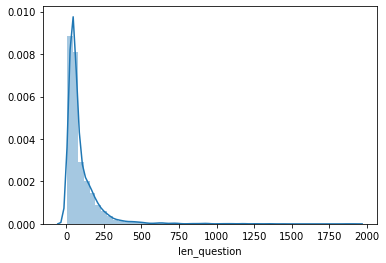

In [27]:
sns.distplot(df['len_question'])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
 <a list of 51 Text xticklabel objects>)

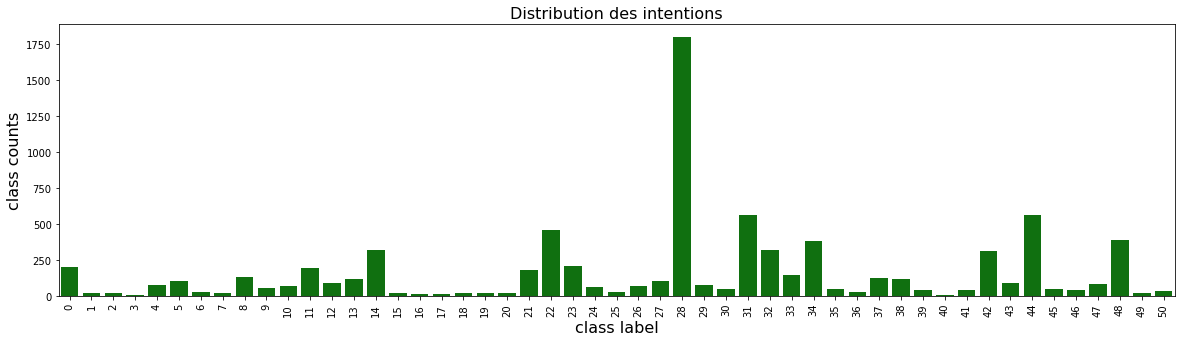

In [28]:
plt.figure(figsize=(20,5))
sns.countplot(x=df['intention'],color = 'green')
plt.title('Distribution des intentions', fontsize=16)
plt.ylabel('class counts', fontsize=16)
plt.xlabel('class label', fontsize=16)
plt.xticks(rotation='vertical')

In [31]:
#encoding list of words
def encoding_doc(token, words):
  return(token.texts_to_sequences(words))

In [32]:
encoded_doc = encoding_doc(word_tokenizer, cleaned_words)

In [208]:
#df['encoded_doc'] = encoding_doc(word_tokenizer, cleaned_words)

In [209]:
#df['encoded_doc']

In [33]:
encoded_doc

[[65,
  2099,
  1041,
  113,
  94,
  3271,
  914,
  19,
  199,
  69,
  87,
  760,
  68,
  3272,
  3273,
  4876,
  146,
  341,
  4877,
  4878,
  2542,
  98,
  98,
  2543,
  1124,
  59,
  371,
  4,
  61,
  270,
  3274,
  54,
  656,
  214,
  1042,
  487,
  4879,
  2100,
  3275,
  29,
  199,
  69,
  63,
  1,
  146],
 [1207, 4880, 30, 208],
 [83,
  1,
  55,
  4881,
  915,
  657,
  310,
  1616,
  1208,
  852,
  853,
  2101,
  580,
  1436,
  611,
  2544,
  4882,
  3276,
  1437,
  1438,
  293,
  33,
  82,
  146,
  311,
  1439,
  54,
  147,
  488,
  64],
 [102, 409, 2102, 151, 3277, 4883],
 [205, 2103, 1300, 3278, 1, 55, 425, 52, 191, 4884, 138, 72, 410],
 [152, 1209, 39, 254, 2, 84, 1810, 2104],
 [4885, 124, 459, 686],
 [11, 399, 208, 159],
 [4886, 46],
 [24,
  99,
  164,
  199,
  25,
  199,
  69,
  1811,
  3279,
  372,
  6,
  47,
  66,
  156,
  293,
  460,
  304,
  502,
  237,
  70,
  1210,
  3280,
  8,
  62,
  238,
  277,
  3281,
  565,
  27,
  3282,
  3283,
  1301,
  3284],
 [440, 473, 3285

In [34]:
#padding (addig zeros at the end of the vector) Teto make them equal length
def padding_doc(encoded_doc, max_length):
  return(pad_sequences(encoded_doc, maxlen = max_length, padding = "post"))

In [35]:
padded_doc = padding_doc(encoded_doc, max_length)

In [36]:
#df['padded_doc'] = padding_doc(encoded_doc, max_length)   marche pas

In [37]:
padded_doc[:5]

array([[  65, 2099, 1041, ...,    0,    0,    0],
       [1207, 4880,   30, ...,    0,    0,    0],
       [  83,    1,   55, ...,    0,    0,    0],
       [ 102,  409, 2102, ...,    0,    0,    0],
       [ 205, 2103, 1300, ...,    0,    0,    0]], dtype=int32)

In [38]:
print("Shape of padded docs = ",padded_doc.shape)

Shape of padded docs =  (8025, 204)


In [39]:
#tokenizer with filter changed
#output_tokenizer = create_tokenizer(unique_intent, filters = '!"#$%&()*+,-/:;<=>?@[\]^`{|}~')


In [40]:
df['intention'].shape

(8025,)

In [41]:
encoded_output = np.array(df['intention']).reshape(len(df['intention']),1)
encoded_output

array([[28],
       [31],
       [28],
       ...,
       [42],
       [14],
       [22]])

In [42]:
encoded_output.shape

(8025, 1)

In [43]:
def one_hot(encode):
    o = OneHotEncoder(sparse = False)
    return(o.fit_transform(encode))

In [44]:
output_one_hot = one_hot(encoded_output)

/Users/vsaliba-/goinfre/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [45]:
encoded_output.shape

(8025, 1)

In [46]:
output_one_hot.shape

(8025, 51)

In [47]:
output_one_hot

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# 4- Training Model

In [48]:
from sklearn.model_selection import train_test_split

In [49]:
train_X, val_X, train_Y, val_Y = train_test_split(padded_doc, output_one_hot, shuffle = True, test_size = 0.2)
val_X

array([[   1,   38,  179, ...,    0,    0,    0],
       [  46,   18,  551, ...,    0,    0,    0],
       [1201,  281,  118, ...,    0,    0,    0],
       ...,
       [  16,   44,  140, ...,    0,    0,    0],
       [ 542, 2941,   30, ...,    0,    0,    0],
       [  28,   17,  338, ...,    0,    0,    0]], dtype=int32)

In [50]:
print("Shape of train_X = %s and train_Y = %s" % (train_X.shape, train_Y.shape))
print("Shape of val_X = %s and val_Y = %s" % (val_X.shape, val_Y.shape))

Shape of train_X = (6420, 204) and train_Y = (6420, 51)
Shape of val_X = (1605, 204) and val_Y = (1605, 51)


In [ ]:
#Shape of train_X = (6420, 204) and train_Y = (6420, 51)
#Shape of val_X = (1605, 204) and val_Y = (1605, 51)

In [321]:
vocab_size
#9622

9622

In [322]:
def create_model(vocab_size, max_length):
    model = Sequential()
    model.add(Embedding(vocab_size, 128, input_length = max_length, trainable = False))
    model.add(Bidirectional(LSTM(128)))
    # model.add(LSTM(128))
    model.add(Dense(32, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(51, activation = "softmax"))
    return model

In [323]:
model = create_model(vocab_size, max_length)
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model.summary()

W0916 15:46:06.563744 140737125143488 deprecation_wrapper.py:119] From /Users/vsaliba-/goinfre/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0916 15:46:06.624413 140737125143488 deprecation_wrapper.py:119] From /Users/vsaliba-/goinfre/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0916 15:46:06.639224 140737125143488 deprecation_wrapper.py:119] From /Users/vsaliba-/goinfre/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0916 15:46:07.102766 140737125143488 deprecation_wrapper.py:119] From /Users/vsaliba-/goinfre/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:148: The name tf.placeholder_with_default 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 204, 128)          1231616   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 51)                1683      
Total params: 1,504,691
Trainable params: 273,075
Non-trainable params: 1,231,616
_________________________________________________________________


In [ ]:
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

hist = model.fit(train_X, train_Y, epochs = 100, batch_size = 32, validation_data = (val_X, val_Y), callbacks = [checkpoint])

# Meilleure accuracy 0,3674 a l'epoch 28, apres val loss ne s'est plus ameliore
loss = 2.4   accuaracy = 0.3674   val loss = 2.58   val accuracy = 0.3526

# REGRESSION LOGISTIQUE

In [51]:
from sklearn.model_selection import train_test_split

In [52]:
#split pour reg logistique
X_train, X_test, y_train, y_test = train_test_split(padded_doc, df['intention'], test_size=0.33, random_state=42)

In [53]:
print("Shape of train_X = %s and train_Y = %s" % (train_X.shape, train_Y.shape))
print("Shape of val_X = %s and val_Y = %s" % (val_X.shape, val_Y.shape))

Shape of train_X = (6420, 204) and train_Y = (6420, 51)
Shape of val_X = (1605, 204) and val_Y = (1605, 51)


In [54]:
logmodel = LogisticRegression(max_iter=100)

In [56]:
logmodel.fit(X_train,y_train)

/Users/vsaliba-/goinfre/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/vsaliba-/goinfre/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/vsaliba-/goinfre/miniconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [57]:
predictions = logmodel.predict(X_test)

In [58]:
from sklearn.metrics import classification_report

In [62]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        65
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        25
           5       0.00      0.00      0.00        36
           6       0.00      0.00      0.00         8
           7       0.00      0.00      0.00         6
           8       0.00      0.00      0.00        48
           9       0.00      0.00      0.00        24
          10       0.00      0.00      0.00        21
          11       0.00      0.00      0.00        58
          12       0.00      0.00      0.00        33
          13       0.00      0.00      0.00        34
          14       0.10      0.01      0.02       109
          15       0.00      0.00      0.00        12
          16       0.00      0.00      0.00         8
          17       0.00    

/Users/vsaliba-/goinfre/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Regression logistique avec 100 repetitions
  accuracy                           0.22      2649
   macro avg       0.02      0.03      0.02      2649
weighted avg       0.08      0.22      0.11      2649
Avec 200 repetitions, pareil 

# XGBoost

In [59]:
boost = XGBClassifier()

In [60]:
X_train, X_test, y_train, y_test = train_test_split(padded_doc, df['intention'], test_size=0.33, random_state=42)

In [61]:
boost.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [63]:
y_pred = boost.predict(X_test)


In [64]:
predictions = [round(value)for value in y_pred]

In [65]:
# evaluate predictions
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predictions)

In [66]:
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 32.50%


In [ ]:
Accuracy XGBoost 32.5%

In [67]:
print ("Score Train -->", round(boost.score(X_train, y_train) *100,2), " %")

Score Train --> 49.55  %


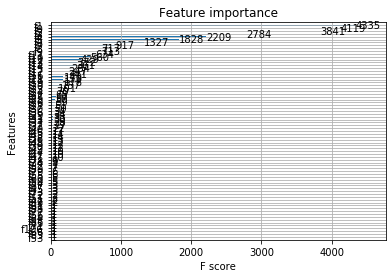

In [68]:
xgb.plot_importance(boost)


# Accuracy XGBoost 32.5%